In [6]:
import argparse
import itertools
import time

import numpy as np
import os
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from data import LatentFeatsConfig, SELECT_DEFAULT, FEATURE_COMBINATION_CHOICES, VISION_FEAT_COMBINATION_CHOICES, \
    LANG_FEAT_COMBINATION_CHOICES, apply_mask, standardize_fmri_betas, \
    standardize_latents, MODALITY_AGNOSTIC, TRAINING_MODES, SPLIT_TRAIN, get_fmri_data, \
    ALL_SPLITS, TEST_SPLITS, get_latents_for_splits, SPLIT_IMAGERY_WEAK, TEST_IMAGES_ATTENDED, TEST_IMAGES_UNATTENDED, \
    TEST_CAPTIONS_UNATTENDED, TEST_CAPTIONS_ATTENDED, MODALITY_SPECIFIC_CAPTIONS, MODALITY_SPECIFIC_IMAGES,  TEST_IMAGES, TEST_CAPTIONS
from eval import pairwise_accuracy, calc_all_pairwise_accuracy_scores
from utils import FMRI_BETAS_DIR, RESULTS_FILE, DEFAULT_MODEL, DEFAULT_RESOLUTION, PREDICTIONS_FILE, HEMIS, \
    SUBJECTS_ADDITIONAL_TEST, ADDITIONAL_TEST_DATA_DIR, FMRI_BETAS_DIR
from analyses.decoding.ridge_regression_decoding import get_fmri_data_for_splits
from scipy.spatial.distance import cdist
from eval import pairwise_accuracy

DECODER_CLASSIFIER_ADDITIONAL_TEST_OUT_DIR = os.path.join(ADDITIONAL_TEST_DATA_DIR, "whole_brain_decoding_classification")
TEST_SPLITS = [TEST_IMAGES_ATTENDED, TEST_CAPTIONS_ATTENDED, TEST_IMAGES_UNATTENDED, TEST_CAPTIONS_UNATTENDED]

In [2]:
results = []
for subject in SUBJECTS_ADDITIONAL_TEST:
    all_fmri_betas, stim_ids, stim_types = get_fmri_data_for_splits(
        subject, TEST_SPLITS, 'agnostic', FMRI_BETAS_DIR, surface=True,
    )
    # for split in all_fmri_betas.keys():
    #     all_fmri_betas[split] = StandardScaler().fit_transform(all_fmri_betas[split]) #TODO

    for training_split in TEST_SPLITS:
        # fmri_betas = standardize_fmri_betas(all_fmri_betas.copy(), fit_on_split=training_split)
        fmri_betas = all_fmri_betas.copy()
        
        fmri_betas_train = fmri_betas[training_split]

        testing_splits = [split for split in TEST_SPLITS if split != training_split]
        for testing_split in testing_splits:
            fmri_betas_test = fmri_betas[testing_split]
            # print(f"testing set shape: {fmri_betas_test.shape} (split: {testing_split})")
            pairwise_acc = pairwise_accuracy(fmri_betas_train, fmri_betas_test, standardize_predictions=False, standardize_latents = False)
            # print(pairwise_acc)
            mode = 'within' if ('caption' in training_split and 'caption' in testing_split) or ('image' in training_split and 'image' in testing_split) else 'cross'
            # print(mode)
            result = {
                'subject': subject,
                'mode': mode,
                'acc': pairwise_acc,
                'train_split': training_split,
                'test_split': testing_split,
            }
                
            print(result)
            results.append(result)

        print('\n\n')
        
results = pd.DataFrame(results)
display(results)


loading sub-01 agnostic left hemi test_image_attended fmri data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:01<00:00, 66.16it/s]
loading sub-01 agnostic right hemi test_image_attended fmri data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:01<00:00, 68.47it/s]
loading sub-01 agnostic left hemi test_caption_attended fmri data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:01<00:00, 67.14it/s]
loading sub-01 agnostic right hemi test_caption_attended fmri data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:0

{'subject': 'sub-01', 'mode': 'cross', 'acc': 0.5256728778467908, 'train_split': 'test_image_attended', 'test_split': 'test_caption_attended'}
{'subject': 'sub-01', 'mode': 'within', 'acc': 0.6666666666666666, 'train_split': 'test_image_attended', 'test_split': 'test_image_unattended'}
{'subject': 'sub-01', 'mode': 'cross', 'acc': 0.5556935817805383, 'train_split': 'test_image_attended', 'test_split': 'test_caption_unattended'}



{'subject': 'sub-01', 'mode': 'cross', 'acc': 0.5556935817805383, 'train_split': 'test_caption_attended', 'test_split': 'test_image_attended'}
{'subject': 'sub-01', 'mode': 'cross', 'acc': 0.4730848861283644, 'train_split': 'test_caption_attended', 'test_split': 'test_image_unattended'}
{'subject': 'sub-01', 'mode': 'within', 'acc': 0.5250517598343686, 'train_split': 'test_caption_attended', 'test_split': 'test_caption_unattended'}



{'subject': 'sub-01', 'mode': 'within', 'acc': 0.6527950310559006, 'train_split': 'test_image_unattended', 'test_split': 'test

loading sub-02 agnostic left hemi test_image_attended fmri data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:01<00:00, 68.84it/s]
loading sub-02 agnostic right hemi test_image_attended fmri data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:01<00:00, 69.46it/s]
loading sub-02 agnostic left hemi test_caption_attended fmri data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 70.60it/s]
loading sub-02 agnostic right hemi test_caption_attended fmri data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:0

{'subject': 'sub-02', 'mode': 'cross', 'acc': 0.5047619047619047, 'train_split': 'test_image_attended', 'test_split': 'test_caption_attended'}
{'subject': 'sub-02', 'mode': 'within', 'acc': 0.6681159420289855, 'train_split': 'test_image_attended', 'test_split': 'test_image_unattended'}
{'subject': 'sub-02', 'mode': 'cross', 'acc': 0.5167701863354037, 'train_split': 'test_image_attended', 'test_split': 'test_caption_unattended'}



{'subject': 'sub-02', 'mode': 'cross', 'acc': 0.48840579710144927, 'train_split': 'test_caption_attended', 'test_split': 'test_image_attended'}
{'subject': 'sub-02', 'mode': 'cross', 'acc': 0.512008281573499, 'train_split': 'test_caption_attended', 'test_split': 'test_image_unattended'}
{'subject': 'sub-02', 'mode': 'within', 'acc': 0.5024844720496895, 'train_split': 'test_caption_attended', 'test_split': 'test_caption_unattended'}



{'subject': 'sub-02', 'mode': 'within', 'acc': 0.6656314699792961, 'train_split': 'test_image_unattended', 'test_split': 'test

loading sub-04 agnostic left hemi test_image_attended fmri data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 70.13it/s]
loading sub-04 agnostic right hemi test_image_attended fmri data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 71.43it/s]
loading sub-04 agnostic left hemi test_caption_attended fmri data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:01<00:00, 69.97it/s]
loading sub-04 agnostic right hemi test_caption_attended fmri data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:0

{'subject': 'sub-04', 'mode': 'cross', 'acc': 0.494824016563147, 'train_split': 'test_image_attended', 'test_split': 'test_caption_attended'}
{'subject': 'sub-04', 'mode': 'within', 'acc': 0.6766045548654245, 'train_split': 'test_image_attended', 'test_split': 'test_image_unattended'}
{'subject': 'sub-04', 'mode': 'cross', 'acc': 0.48612836438923396, 'train_split': 'test_image_attended', 'test_split': 'test_caption_unattended'}



{'subject': 'sub-04', 'mode': 'cross', 'acc': 0.4836438923395445, 'train_split': 'test_caption_attended', 'test_split': 'test_image_attended'}
{'subject': 'sub-04', 'mode': 'cross', 'acc': 0.5198757763975155, 'train_split': 'test_caption_attended', 'test_split': 'test_image_unattended'}
{'subject': 'sub-04', 'mode': 'within', 'acc': 0.5097308488612836, 'train_split': 'test_caption_attended', 'test_split': 'test_caption_unattended'}



{'subject': 'sub-04', 'mode': 'within', 'acc': 0.7022774327122153, 'train_split': 'test_image_unattended', 'test_split': 'test

loading sub-05 agnostic left hemi test_image_attended fmri data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 83.85it/s]
loading sub-05 agnostic right hemi test_image_attended fmri data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 107.22it/s]
loading sub-05 agnostic left hemi test_caption_attended fmri data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 116.54it/s]
loading sub-05 agnostic right hemi test_caption_attended fmri data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00

{'subject': 'sub-05', 'mode': 'cross', 'acc': 0.50351966873706, 'train_split': 'test_image_attended', 'test_split': 'test_caption_attended'}
{'subject': 'sub-05', 'mode': 'within', 'acc': 0.719047619047619, 'train_split': 'test_image_attended', 'test_split': 'test_image_unattended'}
{'subject': 'sub-05', 'mode': 'cross', 'acc': 0.48198757763975153, 'train_split': 'test_image_attended', 'test_split': 'test_caption_unattended'}



{'subject': 'sub-05', 'mode': 'cross', 'acc': 0.505175983436853, 'train_split': 'test_caption_attended', 'test_split': 'test_image_attended'}
{'subject': 'sub-05', 'mode': 'cross', 'acc': 0.5010351966873706, 'train_split': 'test_caption_attended', 'test_split': 'test_image_unattended'}
{'subject': 'sub-05', 'mode': 'within', 'acc': 0.46873706004140786, 'train_split': 'test_caption_attended', 'test_split': 'test_caption_unattended'}



{'subject': 'sub-05', 'mode': 'within', 'acc': 0.7786749482401656, 'train_split': 'test_image_unattended', 'test_split': 'test_i

loading sub-07 agnostic left hemi test_image_attended fmri data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:01<00:00, 69.72it/s]
loading sub-07 agnostic right hemi test_image_attended fmri data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 70.47it/s]
loading sub-07 agnostic left hemi test_caption_attended fmri data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 70.81it/s]
loading sub-07 agnostic right hemi test_caption_attended fmri data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:0

{'subject': 'sub-07', 'mode': 'cross', 'acc': 0.5453416149068323, 'train_split': 'test_image_attended', 'test_split': 'test_caption_attended'}
{'subject': 'sub-07', 'mode': 'within', 'acc': 0.5596273291925465, 'train_split': 'test_image_attended', 'test_split': 'test_image_unattended'}
{'subject': 'sub-07', 'mode': 'cross', 'acc': 0.4939958592132505, 'train_split': 'test_image_attended', 'test_split': 'test_caption_unattended'}



{'subject': 'sub-07', 'mode': 'cross', 'acc': 0.5124223602484472, 'train_split': 'test_caption_attended', 'test_split': 'test_image_attended'}
{'subject': 'sub-07', 'mode': 'cross', 'acc': 0.463768115942029, 'train_split': 'test_caption_attended', 'test_split': 'test_image_unattended'}
{'subject': 'sub-07', 'mode': 'within', 'acc': 0.49047619047619045, 'train_split': 'test_caption_attended', 'test_split': 'test_caption_unattended'}



{'subject': 'sub-07', 'mode': 'within', 'acc': 0.5277432712215321, 'train_split': 'test_image_unattended', 'test_split': 'test

,subject,mode,acc,train_split,test_split
0,sub-01,cross,0.525673,test_image_attended,test_caption_attended
1,sub-01,within,0.666667,test_image_attended,test_image_unattended
2,sub-01,cross,0.555694,test_image_attended,test_caption_unattended
3,sub-01,cross,0.555694,test_caption_attended,test_image_attended
4,sub-01,cross,0.473085,test_caption_attended,test_image_unattended
5,sub-01,within,0.525052,test_caption_attended,test_caption_unattended
6,sub-01,within,0.652795,test_image_unattended,test_image_attended
7,sub-01,cross,0.484886,test_image_unattended,test_caption_attended
8,sub-01,cross,0.432091,test_image_unattended,test_caption_unattended
9,sub-01,cross,0.549275,test_caption_unattended,test_image_attended


,acc
train_test,
test_caption_attended -> test_caption_unattended,0.499296
test_caption_attended -> test_image_attended,0.509068
test_caption_attended -> test_image_unattended,0.493954
test_caption_unattended -> test_caption_attended,0.494037
test_caption_unattended -> test_image_attended,0.506211
test_caption_unattended -> test_image_unattended,0.487992
test_image_attended -> test_caption_attended,0.514824
test_image_attended -> test_caption_unattended,0.506915
test_image_attended -> test_image_unattended,0.658012


(0.48, 0.55)

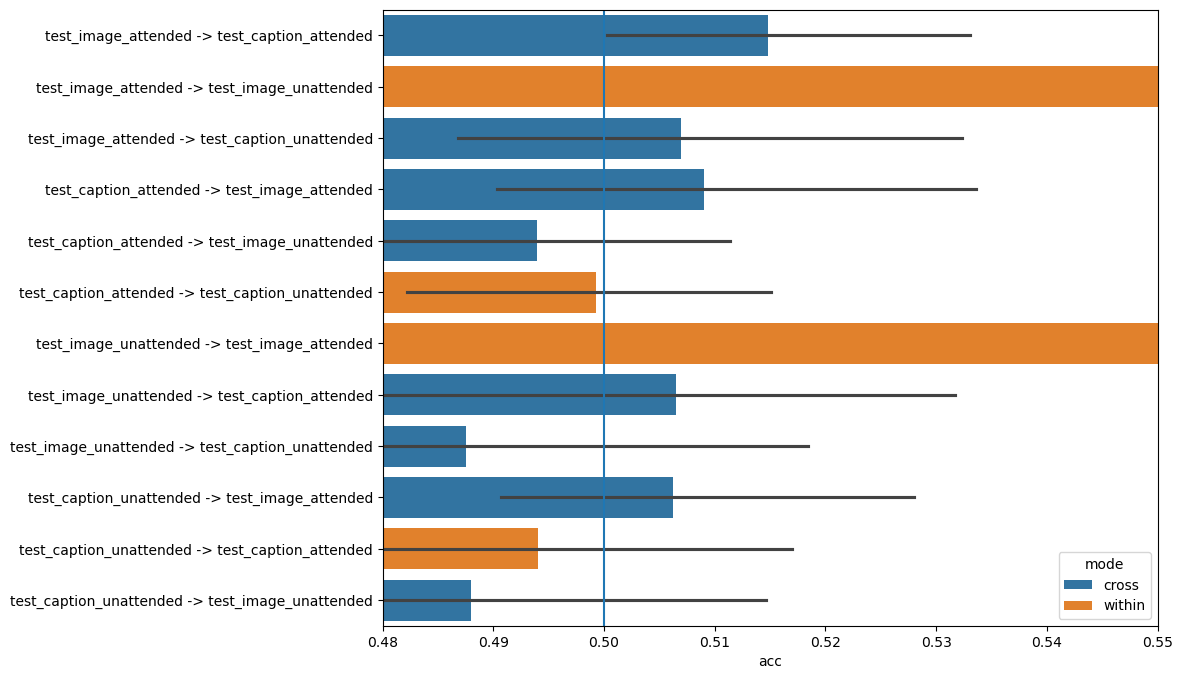

In [16]:
results['train_test'] = results['train_split'] + ' -> ' + results['test_split']

# display(results.groupby(['mode', 'train_test']).agg({'acc': 'mean'}))
display(results.groupby('train_test').agg({'acc': 'mean'}))

plt.figure(figsize=(10,8))
sns.barplot(data=results, y='train_test', x='acc', hue='mode')
plt.ylabel('')
plt.axvline(x=0.5)
plt.xlim((0.48, 0.55))
# print(results.groupby('mode').agg({'acc': 'mean'}))